# Проект: Обучение с учителем: качество модели

К нам обратился интернет-магазин «В один клик» который продаёт разные товары.

Так как последний отчет показал, что активность покупателей стала снижаться, а новых клиентов привлекать трудно, поскольку это известный магазин, то стратегия компании состоит в удержании постоянных клиентов. Для этого они обратились ко мне с просьбой создать модель, которая позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую способность.

В нашем распоряжении несколько датасетов:
- Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
- Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом
- Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
- Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Наш план работы будет состоять из нескольких последовательных этапов:
- [Загрузка библиотек и датасетов](#section1)
- [Проведение предобработки данных](#section2)
- [Исследовательский анализ данных](#section3)
- [Объединение данных](#section4)
- [Корреляционный анализ данных](#section5)
- [Создание модели МО под нашу задачу и выбор лучших параметров для нее](#section6)
- [Анализ важности признаков для лучшей интерпритации модели](#section7)
- [Сегментация покупателей по одному признаку](#section8)
- [Итоговый вывод](#section9)

<a id='section1'></a>
## Загрузка данных

### Загружаем нужные библиотеки и нужные модули

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -U scikit-learn -q

In [3]:
!pip install phik -q

In [4]:
!pip install shap -q

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
from matplotlib import pyplot as plt
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Загружаем датасеты

In [6]:
data_main = pd.read_csv('/datasets/market_file.csv')
data_market_money = pd.read_csv('/datasets/market_money.csv')
data_market_time = pd.read_csv('/datasets/market_time.csv')
data_money_3month = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

**data_main** содержит информацию о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении

**data_market_money** содержит информацию о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом

**data_market_time** содержит информацию о времени (в минутах), которое покупатель провёл на сайте в течение периода

**data_money_3month** содержит информацию о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

<a id='section2'></a>
## Предобработка данных

### Более подробно изучим датасет data_main

In [7]:
data_main.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


Давайте приведем названия столбцов к "питоновскому" регистру.

In [8]:
data_main.columns = map(str.lower, data_main.columns)
data_main.columns = data_main.columns.str.replace(' ', '_')

Теперь проверим данные на пропуски и тип данных

In [9]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

Как мы видим в данных нет пропусков, а также тип данных соответствует самим данным. В случае нахождения пропусков, мы бы анализировали их объем, чтобы определить что можно сделать. Если бы в данных было бы очень мало пропусков, то их можно было бы удалить, но по возможности желательно пропуски заполнять модой, медианной или средней в зависимости от ситуации.

Теперь проверим значения в категориальных столбцах во избежании дубликатов.

In [10]:
cat_column = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for i in cat_column:
    print(f'Уникальные значения в столбце {i}: {data_main[i].unique()}', '\n')

Уникальные значения в столбце покупательская_активность: ['Снизилась' 'Прежний уровень'] 

Уникальные значения в столбце тип_сервиса: ['премиум' 'стандартт' 'стандарт'] 

Уникальные значения в столбце разрешить_сообщать: ['да' 'нет'] 

Уникальные значения в столбце популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника'] 



Как можно заменить существует неявный дубликат в столбце **тип сервиса**. Заменим данное значение

In [11]:
data_main['тип_сервиса'] = data_main['тип_сервиса'].replace('стандартт', 'стандарт')
data_main['популярная_категория'] = data_main['популярная_категория'].replace('Косметика и аксесуары',
                                                                              'Косметика и аксессуары')

In [12]:
data_main['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Теперь проверим данные на явные дубликаты

In [13]:
data_main.duplicated().sum()

0

Так как ID это уникальный идентификатор, нужно проверить, чтобы все значения были уникальные

In [14]:
data_main['id'].nunique()

1300

Если бы были бы повторы в ID мы бы взгянули на данные этих дублей и проверили бы что пошло не так и что можно с ними делать

Столбцы переименовали, неверное значение заменили, явных дубликатов не нашли, все id уникальны. Можно идти дальше

### Более подробно изучим датасет data_market

In [15]:
data_market_money.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


Давайте приведем названия столбцов к "питоновскому" регистру.

In [16]:
data_market_money.columns = map(str.lower, data_market_money.columns)

Теперь проверим данные на пропуски и тип данных

In [17]:
data_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [18]:
data_market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Нет ошибок которые нужно исправить

In [19]:
data_market_money['id'].nunique()

1300

Как мы видим в данных нет пропусков, а также тип данных соответствует самим данным. Также данных ровно в 3 раза больше, но уникальных id такое же количество, что должно соотетвовать действительности, так как на каждое id должно быть 3 разных периода

### Более подробно изучим датасет data_market_time

In [20]:
data_market_time.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


Давайте приведем названия столбцов к "питоновскому" регистру.

In [21]:
data_market_time.columns = map(str.lower, data_market_time.columns)

In [22]:
data_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [23]:
data_market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [24]:
data_market_time['период'] = data_market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [25]:
data_market_time['id'].nunique()

1300

Как мы видим в данных нет пропусков, а также тип данных соответствует самим данным. По количеству id тоже все хорошо

### Более подробно изучим датасет data_money_3month

In [26]:
data_money_3month.head(10)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


Давайте приведем названия столбцов к "питоновскому" регистру.

In [27]:
data_money_3month.columns = map(str.lower, data_money_3month.columns)

In [28]:
data_money_3month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [29]:
data_money_3month['id'].nunique()

1300

Как мы видим в данных нет пропусков, а также тип данных соответствует самим данным.

Стоит заметить, что данные были очень хорошими. Ни в одном датасете не было пропусков или неверного типа данных из-за каких либо ошибок. Единственное, что мы сделали это привели данные в "питоновский" регистр. Также в каждом датасете есть столбец с ID, по которому можно будет объединить все 4 датасета в будущем. Главное после объединения сделать проверку, что все 1300 id были одинаковыми

<a id='section3'></a>
## Исследовательский анализ данных

### Анализ категориальных столбцов data_main

Проанализируем данные категориальных столбцов. Для этого построим графики распределения данных признаков. Сделаем столбчатую и круговую диаграмму, чтобы лучше оценить данные. Также мы напишем функцию, чтобы не повторять однотипный код. Мы не будем данную функцию закладывать в цикл, чтобы делать мини выводы после каждого столбца, а не в конце графиков

Начнем со стобца **покупательская_активность**

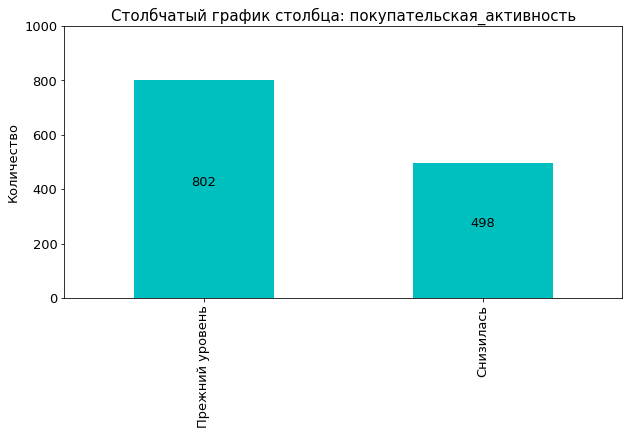

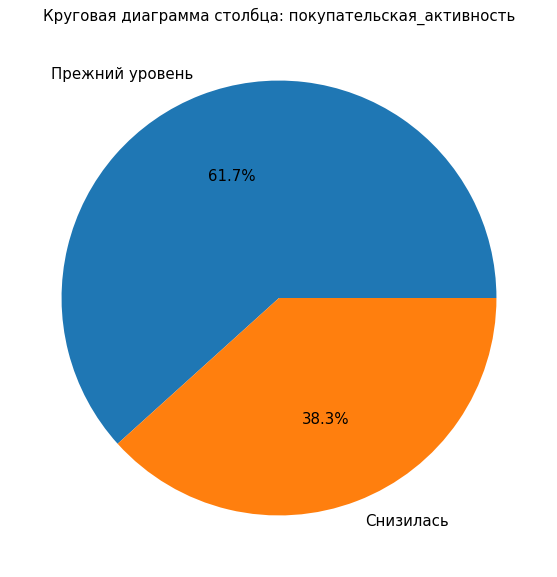

In [30]:
def category_data_graf(dataset, column):
    '''Данная функция берет на себя функцию построения столбчатой и круговой диаграммы, 
    для определния распределения и доли. 
    Аргументы:
    dataset - выбор датасета (значение без кавычек)
    columns - выбор столбца для построения графиков (значение в кавычках)'''
    
    data_cat_graf = dataset[column].value_counts()

    plt.figure(figsize=(10,5))
    data_cat_graf.plot(kind='bar', color='c', fontsize=13)

    for i, val in enumerate(data_cat_graf.values):
        plt.text(i, val/2, int(val),
                 horizontalalignment='center', 
                 verticalalignment='bottom',
                 fontweight='book',
                 fontdict={'fontweight':1500, 'size':13},
                 )
    plt.title(f'Столбчатый график столбца: {column}', fontsize=15)
    plt.ylabel('Количество',fontsize=13)
    plt.ylim(0,1000)
    plt.show()
    
    plt.title(f'Круговая диаграмма столбца: {column}', fontsize=15)
    data_cat_graf.plot(kind='pie', figsize =(10,10), fontsize=15,
                       autopct=lambda p: '{:.1f}%'.format(p,(p/100)*data_cat_graf.sum()))
    plt.ylabel('')
    
category_data_graf(data_main, 'покупательская_активность')

Как мы видим покупательская активность снизилась примерно у 40% пользователей. Поскольку это наш целевой признак, то это влияет на несколько параметров: 

1- Выбор метрики. Accuracy не подходит, поскольку уже есть смещение к одному классу.
2- Разбивка на выборки. Нужно добавлять стратификацию, чтобы это учесть

Проверим данные столбца **тип сервиса**

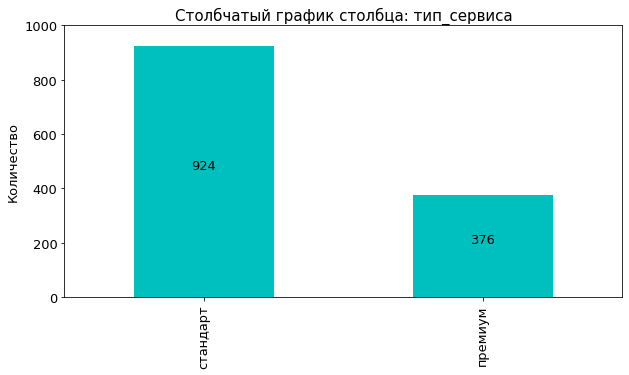

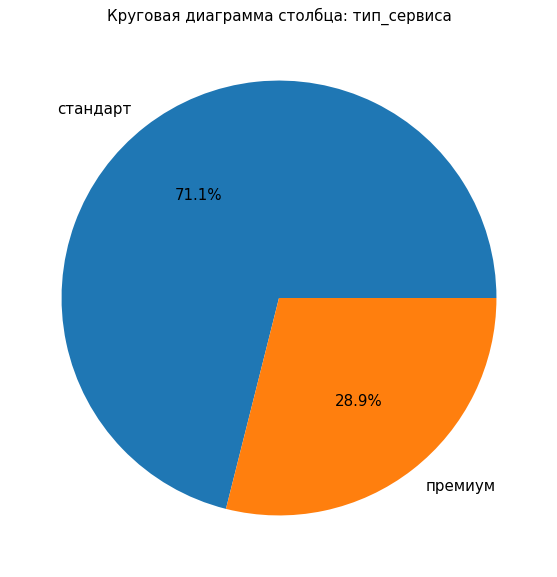

In [31]:
category_data_graf(data_main, 'тип_сервиса')

30% клиентов оформили премиум сервис

Проверим данные стобца **разрешить_сообщать**. Это столбец с данными можно ли присылать покупателю дополнительные предложения о товаре

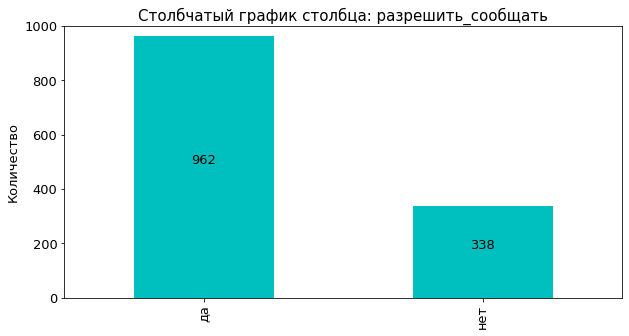

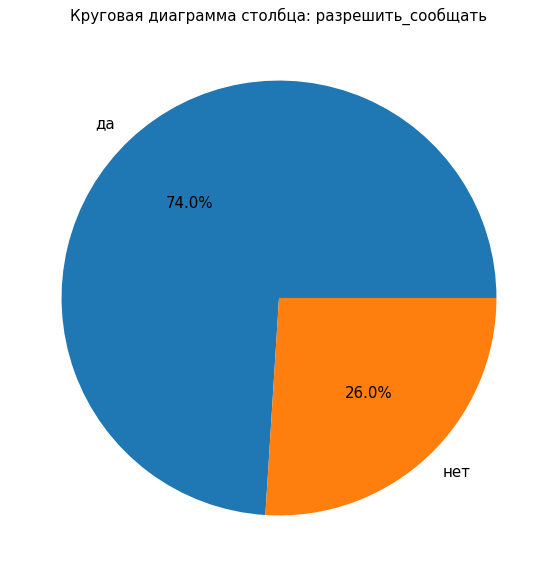

In [32]:
category_data_graf(data_main, 'разрешить_сообщать')

74% процента пользователей разрешили высылать им сообщения о дополнительных акциях

Теперь проверим столбец **популярная_категория**

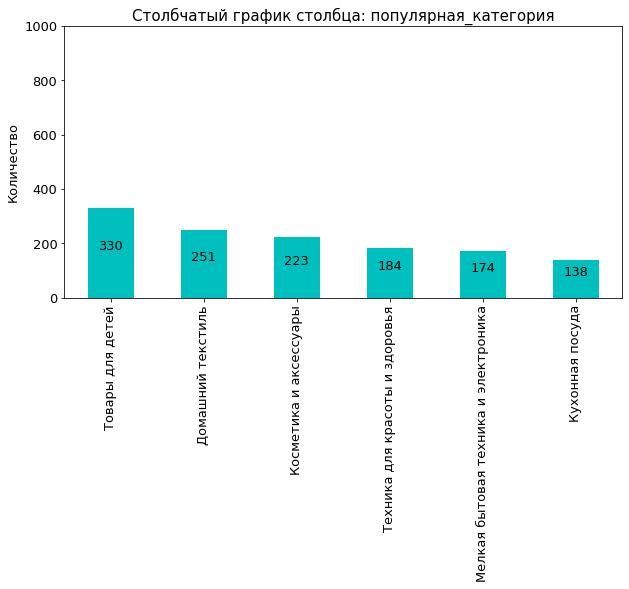

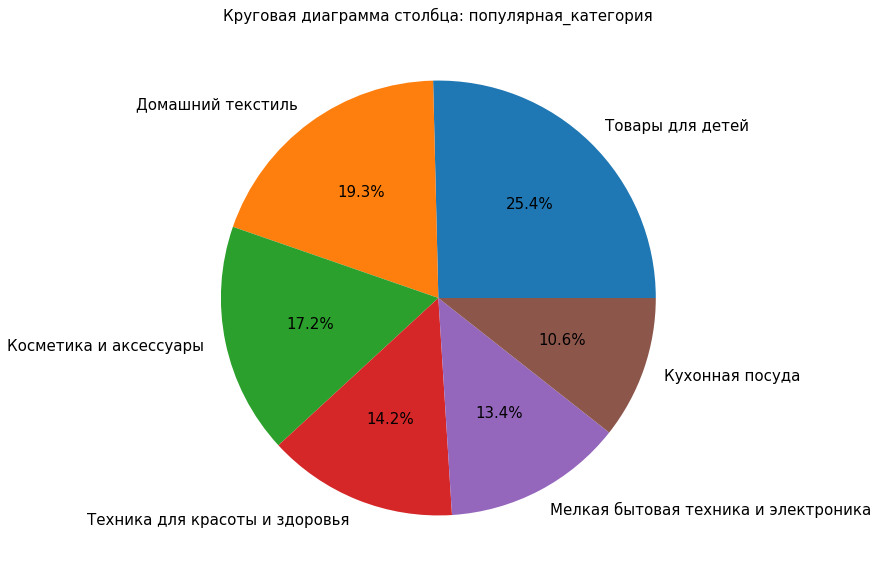

In [33]:
category_data_graf(data_main, 'популярная_категория')

Найболее популярная категория это Товары для детей. На нее приходится четверть всех данных.

Проверим столбец **маркет_актив_тек_мес**. Данный столбце мы проверим с помощью категориальных графиков из-за низкого числа значений

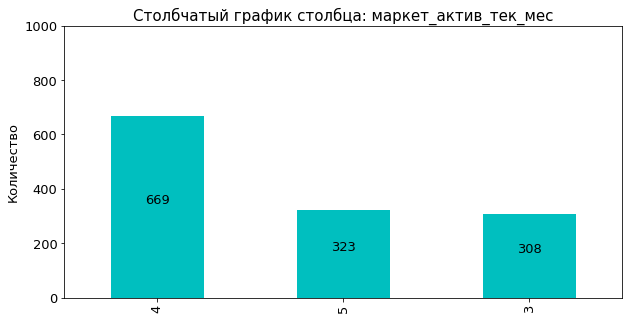

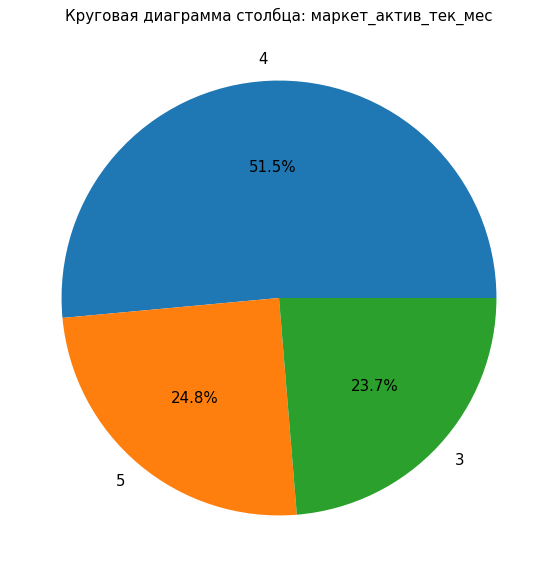

In [34]:
category_data_graf(data_main, 'маркет_актив_тек_мес')

Как мы видим половина пользователей получила 4 маркетинговых коммуникации в этом месяце. 

### Анализ количественных столбцов data_main

По аналогии с предыдущим этапом мы напишем функцию, чтобы выводить гитограмму, а также для определения выбросов построим "Ящик с усами"

Проверим столбец **маркет актив 6 мес**

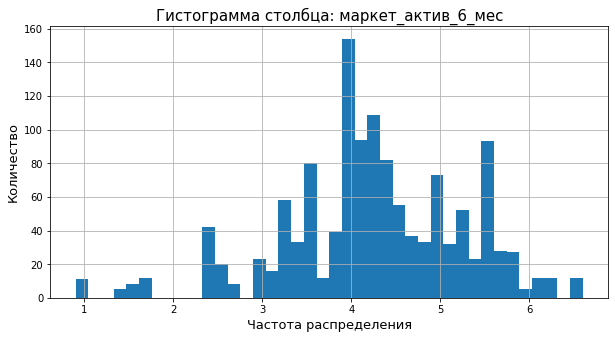

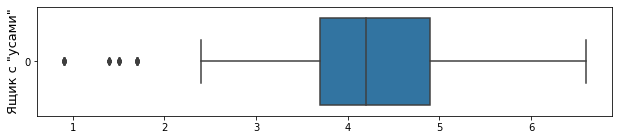

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


In [35]:
def number_data_graf(dataset, column, bins):
    '''Данная функция берет на себя функцию построения гистограммы, а также "Ящик с усами", 
    для определния распределения и выбросов. 
    Аргументы:
    dataset - выбор датасета (значение без кавычек)
    columns - выбор столбца для построения графиков (значение в кавычках)
    bins - число столбцов в гистограмме'''
    
    plt.figure(figsize=(10,5))
    dataset[column].hist(bins=bins)
    plt.title(f'Гистограмма столбца: {column}', fontsize=15)
    plt.xlabel('Частота распределения',fontsize=13)
    plt.ylabel('Количество',fontsize=13)
    plt.show()
    
    plt.figure(figsize=(10.3, 2))
    sns.boxplot(data=dataset[column], orient='h')
    plt.ylabel('Ящик с "усами"',fontsize=13)
    plt.show()
    
    print(dataset[column].describe())

number_data_graf(data_main, 'маркет_актив_6_мес', 40)

Среднее и мидиана находятся в районе 4.2 маркетинговых активности за 6 месяцев. Хоть у нас есть 4 выброса с активностями меньше 2, мы их не будем удалять так как это могут быть новые пользователи, у которых ее не было много активностей.

Проверим столбец **длительность**

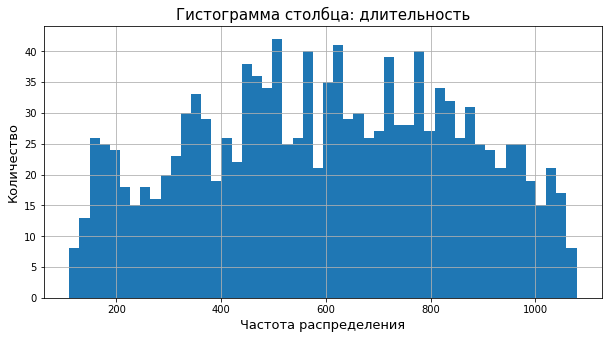

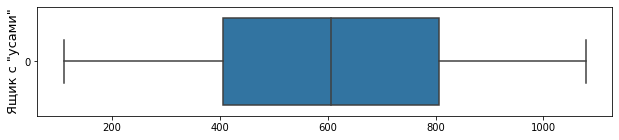

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64


In [36]:
number_data_graf(data_main, 'длительность', 50)

Самый "молодой пользователь" зарегистрирован 110 дней, а самый "старый" уже 1079 дней. Как мы видим нет аномальных значений или выбросов

Проверим столбец **акционные_покупки**

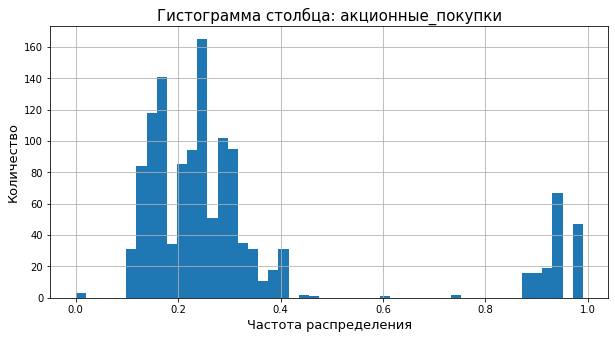

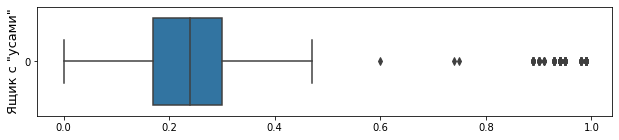

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


In [37]:
number_data_graf(data_main, 'акционные_покупки', 50)

Как мы видим существую пользователи которые очень часто покупают акционные товары и если человек берет более половины всех покупок по акции, то это уже проходит как выброс. В среднем около четверти покупок совершаются по акции

Проверим столбец **средний_просмотр_категорий_за_визит**

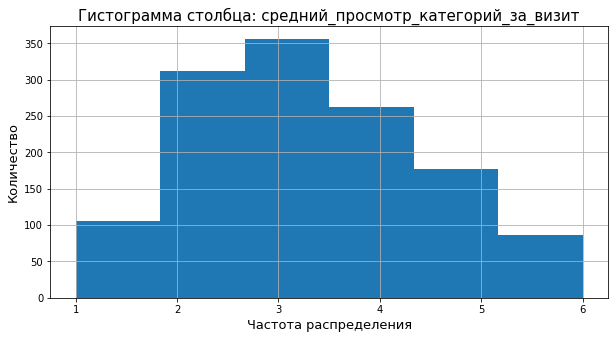

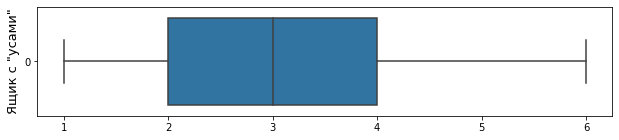

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64


In [38]:
number_data_graf(data_main, 'средний_просмотр_категорий_за_визит', 6)

Большинство просмотров приходятся от 2 до 4 категории за визит, при этом можно заметить, что количество просмотренных категории растет до 3, а затем начинает падать. Анномалии нет

Проверим столбец **неоплаченные_продукты_штук_квартал**

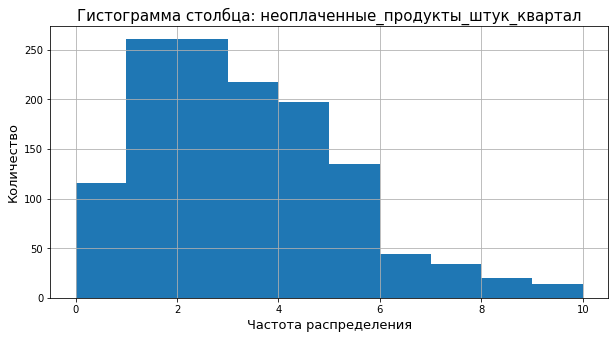

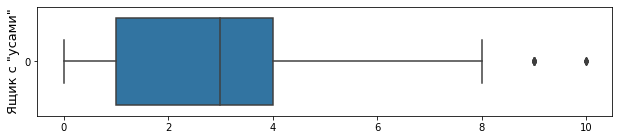

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


In [39]:
number_data_graf(data_main, 'неоплаченные_продукты_штук_квартал', 10)

В среднем отказываются от 3-х покупок в квартал. Значения более 8 уже являются выбросами

Проверим столбец **ошибка_сервиса**

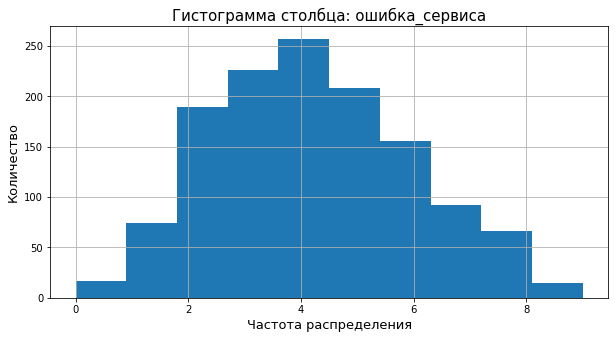

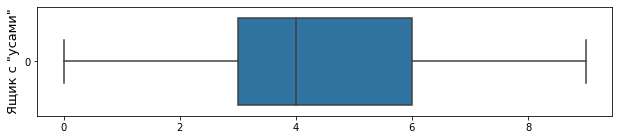

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64


In [40]:
number_data_graf(data_main, 'ошибка_сервиса', 10)

В среднем пользователи сталкиваются с 4 ошибками сервиса.

Проверим столбец **страниц_за_визит**

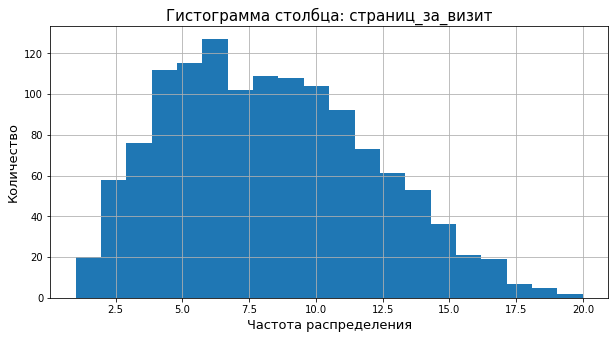

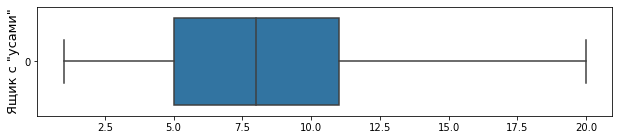

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64


In [41]:
number_data_graf(data_main, 'страниц_за_визит', 20)

Среднее значение это 8 страниц за сессию, а максимальное это 20 страниц

### Анализ файла data_market_money

Давайте проверим данные по **выручка**

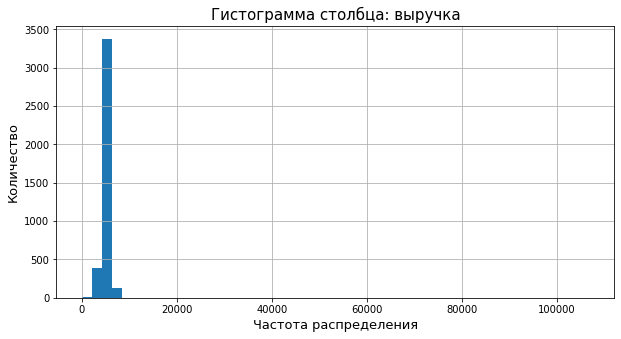

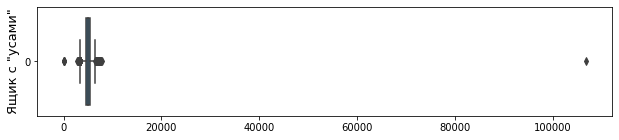

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64


In [42]:
number_data_graf(data_market_money, 'выручка', 50)

Как мы видим у нас есть один очень большой выброс. Давайте его проверим, а также данные этого ID

In [43]:
data_market_money[data_market_money['выручка'] > 20000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [44]:
data_market_money[data_market_money['id'] == 215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


Так как мы не можем уточнить, что это за выброс, то предположим, что имеет место ошибка и сумма увеличина на 100000. Скорректируем данный момент

In [45]:
data_market_money['выручка'].loc[98] = data_market_money['выручка'].loc[98] - 100000

In [46]:
data_market_money[data_market_money['id'] == 215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,6862.2


Теперь посмотрим на данные с нулевой выручкой

In [47]:
data_market_money[data_market_money['выручка'] < 2000]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Как мы видим тут нет пользователя который бы в течении 3-х месяцев ничего не покупал

Изменили данный выброс, теперь снова глянем на график

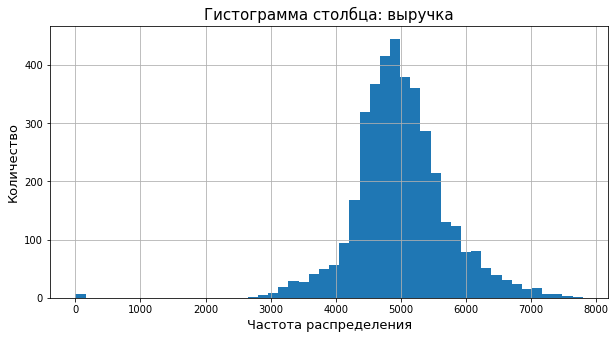

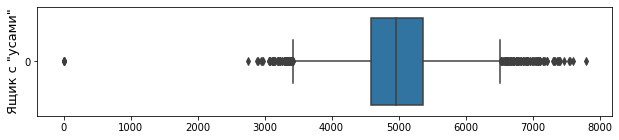

count    3900.000000
mean     5000.055026
std       707.538134
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64


In [48]:
number_data_graf(data_market_money, 'выручка', 50)

Давайте посмотрим на этот же график, но только не будем включать нулевые продажи.

In [49]:
data_market_money_wo_zero = data_market_money[data_market_money['выручка'] > 2000]

In [50]:
data_market_money_wo_zero = data_market_money_wo_zero.reset_index(drop=True)

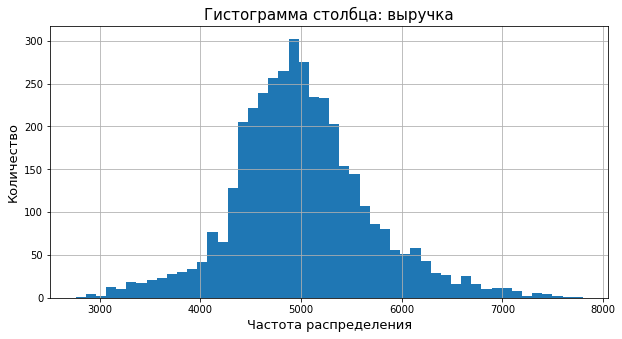

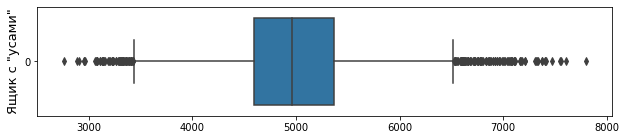

count    3894.000000
mean     5007.759271
std       680.287330
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.300000
max      7799.400000
Name: выручка, dtype: float64


In [51]:
number_data_graf(data_market_money_wo_zero, 'выручка', 50)

Как вы видим если мы не берем в расчет нулевые продажи это не сильно влияет на наши результаты. Средняя выручка в месяца в районе 5000.

Теперь давайте глянем на выручку в каждом месяце

In [52]:
data_pivot = data_market_money.pivot_table(index = 'период', values = 'выручка', aggfunc = {'sum', 'mean'})
data_pivot.sort_values(by='sum', ascending=False)

,mean,sum
период,,
текущий_месяц,5238.037769,6809449.1
предыдущий_месяц,4936.920385,6417996.5
препредыдущий_месяц,4825.206923,6272769.0


Как мы видим выручка растет на протежении последних 3-х месяцев

Выброс устранили, данные изучили идем к следующему файлу

### Анализ файла data_market_time

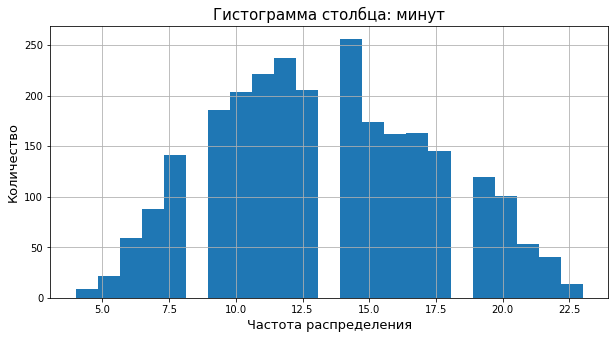

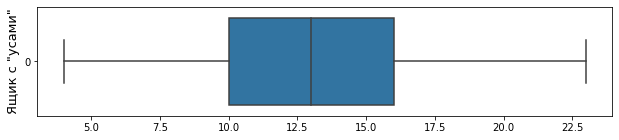

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


In [53]:
number_data_graf(data_market_time, 'минут', 23)

Как мы видим график не имеет выбросов, а также имеет нормально распределение. Среднее время нахождение на сайте 13 минут.

In [54]:
data_pivot = data_market_time.pivot_table(index = 'период', values = 'минут', aggfunc = {'sum', 'mean'})
data_pivot.sort_values(by='sum', ascending=False)

,mean,sum
период,,
предыдущий_месяц,13.467692,17508.0
текущий_месяц,13.204615,17166.0


Можно заметить, что среднее время нахождения на сайте упало, по сравнению с предыдущим месяцем

### Анализ файла data_money_3month

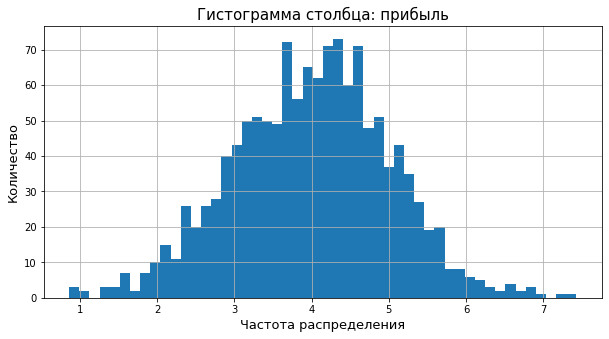

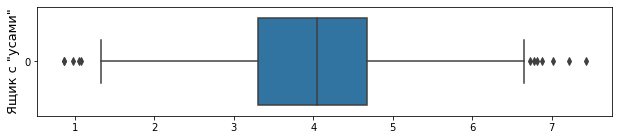

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64


In [55]:
number_data_graf(data_money_3month, 'прибыль', 50)

Выбросы не являются аномалиями, как в случае с выручкой. Средняя оценка прибыли в районе 4

Давайте посмотрим, а есть ли клиенты которые ничего не приобритали за последние 3 месяца <a id='comment1'></a>

In [56]:
data_money_3month['прибыль'].min()

0.86

Как мы видим у нас нет клиентов, которые ничего не приобретали за последние 3 месяца. Если бы такие клиенты были, то нужно было бы уточнить у заказчика оставлять их в исследований или нет, а также провести их более точный анализ, чтобы понять, что могло пойти не так.

По результатам данного блока, можно увидеть, что количественные столбцы имеют нормальное распределение, был только 1 выборс, выручка в текущем месяце больше, чем в прошлом, время нахождения на сайте упало. Далее будем более подробно изучать те признаки, которые влияют на результат нашей одели МО. 

<a id='section4'></a>
## Объединение таблиц

После исправления всех моментов в файлах, а также его исследовательского анализа можем объединить наши датасеты в один. Ключевым моментом будет наш ID, а также нужно понимать, что в разных файлах разное количество повторения одного и того же id, что тоже нужно учесть. 

Для начала через сводные преобразовываем данные в файлах data_market_money и data_market_time, чтобы избавится от повторения id

In [57]:
data_pivot_money = data_market_money.pivot_table(index = 'id', columns='период', values='выручка')
data_pivot_time = data_market_time.pivot_table(index = 'id', columns='период', values='минут')

Теперь преобразуем индексы data_main в id, чтобы объеденять данные по id, а не по строкам

In [58]:
data_full = data_main.set_index('id')

Теперь объеденим данные из 3-х таблиц. Во второе объединение добавим параметр suffixes, чтобы можно было понимать из какой таблицы какие данные, так как столбцы в data_pivot_money и data_pivot_time имеют одинаковые названия

In [59]:
data_full = data_full.merge(data_pivot_money, on='id', how='outer')
data_full = data_full.merge(data_pivot_time, on='id', how='outer', suffixes=["_выручка", "_минут"])

Так как столбец препредыдущий_месяц был только в data_pivot_money, то изменим его под стилистику других столбцов из этой таблицы

In [60]:
data_full.rename(columns={'препредыдущий_месяц': 'препредыдущий_месяц_выручка'}, inplace=True)

Чтобы проверить, что данные успешно объеденились, у нас должны соблюдаться следующие условия:
- Так как мы использовали тип объединения outer, то у нас не должно было появится пропусков
- Количество строк, должно составлять 1300 значений уникальных id
- Количество столбцов должно быть равным стобцам из 3-х датасетов после преобразования (12+3+2=17)

In [61]:
data_full.head(5)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [62]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1300 non-null   object 
 1   тип_сервиса                          1300 non-null   object 
 2   разрешить_сообщать                   1300 non-null   object 
 3   маркет_актив_6_мес                   1300 non-null   float64
 4   маркет_актив_тек_мес                 1300 non-null   int64  
 5   длительность                         1300 non-null   int64  
 6   акционные_покупки                    1300 non-null   float64
 7   популярная_категория                 1300 non-null   object 
 8   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  ошибка_сервиса                       1300 non-null   int64  
 11  страниц_за_визит       

Как мы видим у нас нет пропусков в данных, 1300 уникальных id и 17 столбцов. Также тип данные соответствует данным в этих столбцах. Объединение прошло успешно.

<a id='section5'></a>
## Корреляционный анализ

Поскольку важно не забывать проверять признаки на корреляцию, посторим несколько корреляционных матриц. Начнем с корреляции Пирсона.

<AxesSubplot:>

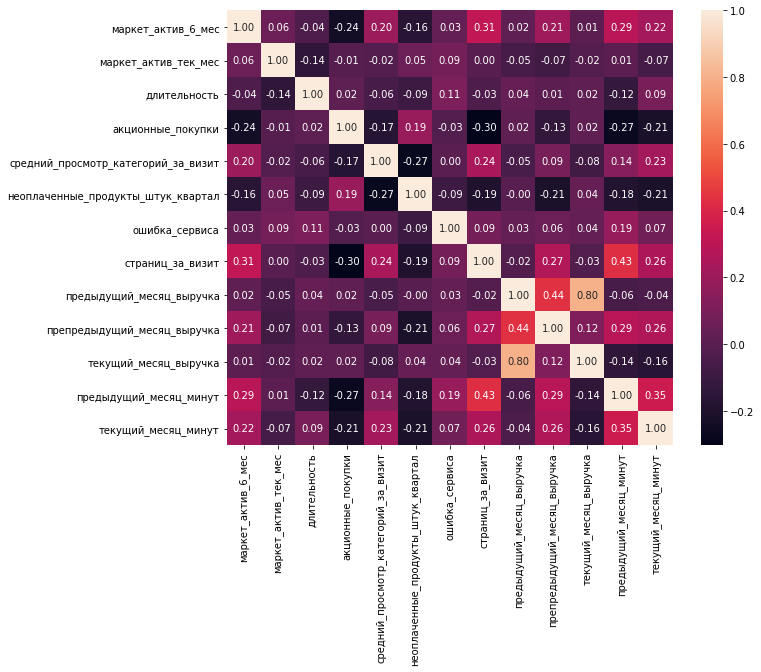

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_full.corr(), annot=True, fmt='.2f') 

Минус данной корреляции, что тут нет данных типа object, а также нашего целевого признака покупательская_активность. Также Пирсоном нужно пользоваться, только при наличии нормально распределния. Как вариант можно в встроеной функции corr указать метод method='spearman', но останется вопрос с категориальными признаками. Чтобы устранить этот момент проведем корреляцию методом Phik, так как она более универсальна для данного исследования.

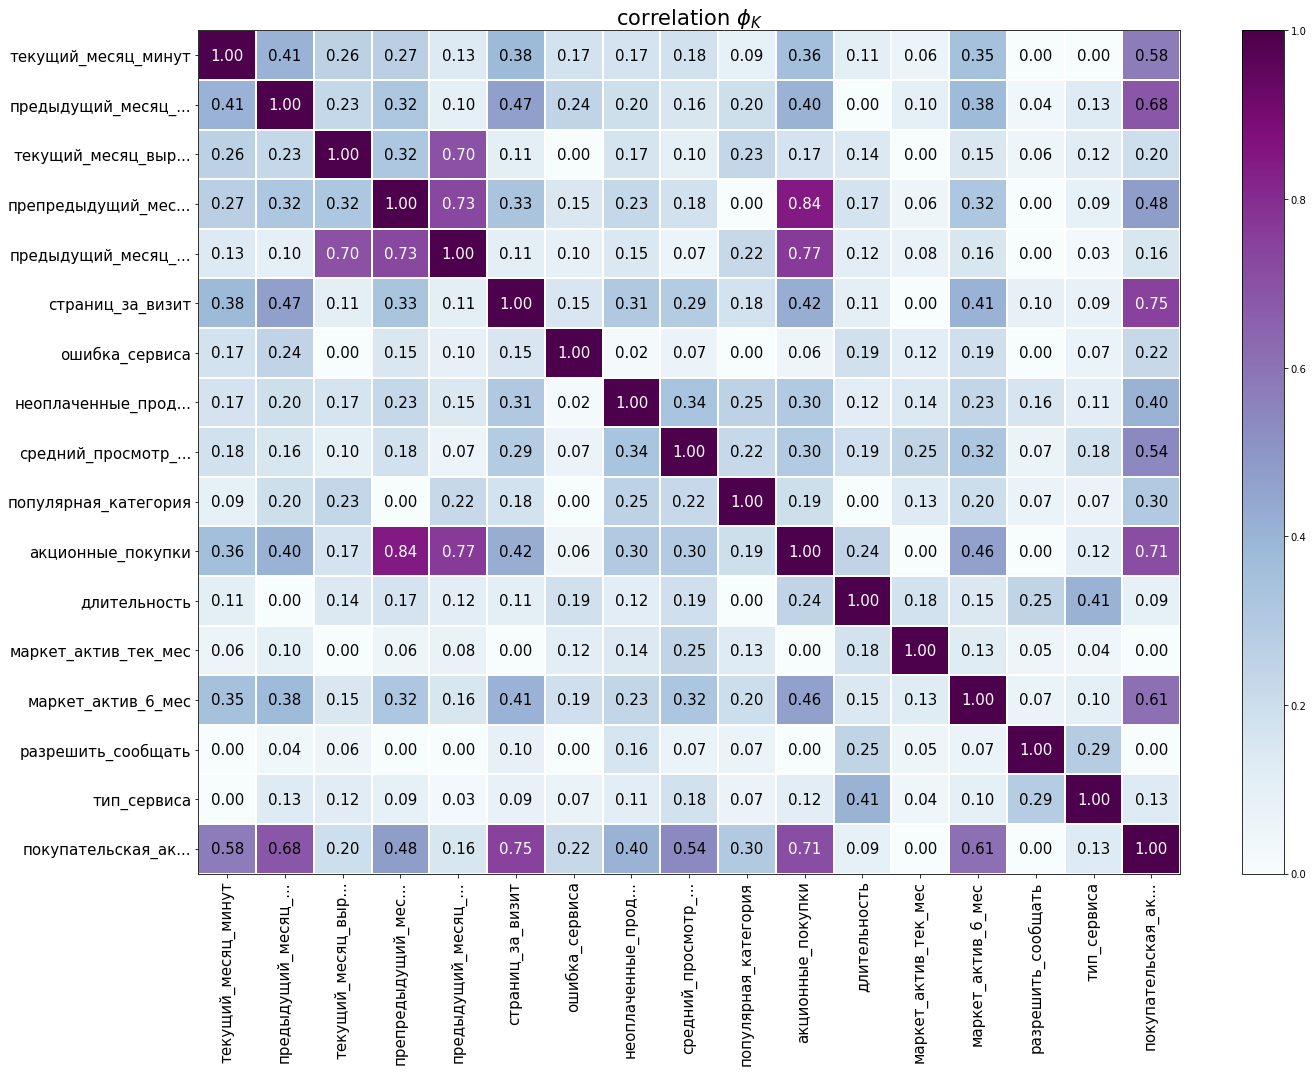

In [64]:
interval_cols = ['длительность', 'предыдущий_месяц_выручка', 
                 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка',
                 'предыдущий_месяц_минут', 'текущий_месяц_минут']

phik_overview = phik_matrix(data_full, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='BuPu',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Как мы видим в данной матрице у нас нет признаков с сильной мультиколениарностью по шкале Чеддока. Самый большой показатель есть между акционными покупками и препредыдущий месяц, скорее всего это было связано с акциями в тот период. Наш целевой признак "покупательская активность" больше всего связан с количеством посещенных страниц за визит и акционными покупками.

На текущий момент мы не будем удалять наши признаки, так как нет сильной мультиколлениарности, но при созданиий модели, возможно, удалим признаки которые не будут влиять на модель, так как даже сейчас есть 0 коллениарность между целевым признаком и некоторыми столбцами нашего датасета

<a id='section6'></a>
## Создание и выбор лучшей модели МО

У нас имеется задача бинарной класификации. Для ее решения нам может подойти одна из 4-х моделей:
- Модель логистической регрессии
- Модель опорных векторов
- Дерево решении
- Метод ближайших соседей

Чтобы не подбирать модель и ее гиперпораметры вручную мы создадим пайплайн, и воспользуемся методом GridSearchCV для поиска лучших гиперпараметров модели. Можно было бы пользоваться методом RandomSearchCV, для экономий времени, но так как у нас не много параметров, то проверим все возможные комбинации

Для начала вручную перекодирую значение в целевом признаке c помощью LabelEncoder, а уже для пайплайна воспользуемся другими, более подходящими кодировщиками.

In [65]:
label_encoder = LabelEncoder()
data_full['покупательская_активность'] = label_encoder.fit_transform(data_full['покупательская_активность'])
data_full['покупательская_активность'] = pd.Series(data_full['покупательская_активность'], dtype="int")
data_full['покупательская_активность'] = 1 - data_full['покупательская_активность']

Немного изменю свой стиль комментирования, чтобы весь код был в одном месте и не разбивался ячейками с комментариями.

In [66]:
# Отдаем приказ 66, чтобы исключить разные данные в разбивке выборок, 
# а также делим данные в разрезе 75% тренировочных данных и 25% тестовых
RANDOM_STATE = 66
TEST_SIZE = 0.25

# Делим данные на выборки и фиксируем рандомность и размер выборок.
# Дополнительно не забываем про стратификацию по целевомцу признаку, чтобы модель учитывала этот параметр
X_train, X_test, y_train, y_test = train_test_split(
    data_full.drop(['покупательская_активность'], axis=1),
    data_full['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_full['покупательская_активность'])

# Cоздаём список с названием столбцов для кодирования принципом OneHotEncoder
ohe_columns = ['популярная_категория', 'разрешить_сообщать']

# Cоздаём список с названием столбцов для кодирования принципом OrdinalEncoder
ord_columns = ['тип_сервиса']

# Cоздаём список с названием столбцов для масштабирования нумерических признаков
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка',
               'текущий_месяц_выручка', 'предыдущий_месяц_минут', 'текущий_месяц_минут']

# Создаём пайплайн для подготовки признаков из списка ohe_columns
# Чтобы сделать наш пайплайн универсальным, мы добавим в них возможность заполнения пустых значений модой через SimpleImputer 
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# Создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough', 
)

# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # Создаем словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # Создаем словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # Создаем словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear',
        )],
        'models__penalty' : ['l1','l2'],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # Создаем словарь для модели SVC()
    {
        'models': [SVC(
                   random_state=RANDOM_STATE,
                   probability=True)
                  ],
        'models__kernel' : ['rbf','sigmoid', 'linear', 'poly'],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке с кросвалидацией:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred_proba = randomized_search.predict_proba(X_test)
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC_AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba[:,1])}')
print(f'Метрика accuracy на тестовой выборке: {accuracy_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                 

Выведем параметры для лучшей модели

In [67]:
randomized_search.best_params_

{'preprocessor__num': StandardScaler(),
 'models__penalty': 'l1',
 'models__C': 2,
 'models': LogisticRegression(random_state=66, solver='liblinear')}

Для качества модели мы используем метрику ROC_AUC поскольку у нас есть смещение значений в целевом притзнаке (60% на 40%), что немного исказит accuracy и у нас нет условия от заказчика, чтобы мы отслеживали recall и precision. В данном случае ROC_AUC лучше покажет именно качество модели. Как мы видим на тестовой выборке качество состовляет 0.9063, что не сильно отличается от тренировочных данных и значений 0.9062, а значит нет проблемы в переобучении модели. 
Для тестовых данных возмем еще и accuracy, для большей наглядности.

Лучшая модель оказалась модель логистической регрессии. Показатель ROC_AUC на тестовых данных составила 0.90, а точность модели на тестовой выборке получилось 0.87.

Пайплайны позволяют быстрее и удобнее настраивать гиперпараметры, что позволяет лучше оптимизировать код. Следующим шагом будет проверка важности признаков, так как нужно понимать на что модель ориентируется для интерпритации ее результатов

<a id='section7'></a>
## Анализ важности признаков

Воспользуемся методом SHAP, чтобы увидеть на какие показатели ориентируется модель

In [68]:
pipe_final['preprocessor'].fit(X_train, y_train)
scaller = pipe_final.named_steps['preprocessor']
col_names = scaller.get_feature_names_out()

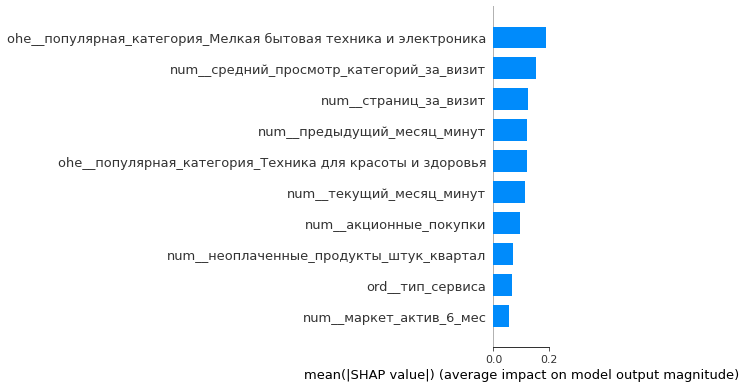

In [69]:
X_train_shap = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_shap = pipe_final.named_steps['preprocessor'].transform(X_test)

X=X_train_shap
X=pd.DataFrame(data=X, columns=col_names)

explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X)
shap_values = explainer(X)
shap.summary_plot(shap_values, plot_type='bar', max_display=10)

Как мы видим самыми важными факторами являются сколько категории и страниц было просмотрено, а также время на сайте. Данный график не показывает в какую сторону влияют данные показатели. Посмотрим на это с помощью beeswarm

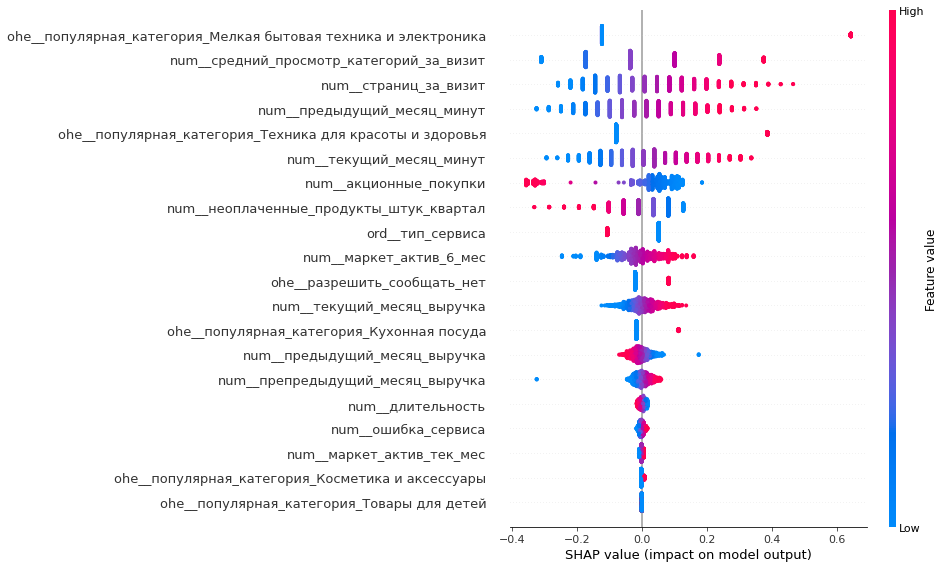

In [70]:
shap.plots.beeswarm(shap_values, max_display=21)

Как мы видим топ 6 признаков с увеличением показателей увеличивают шанс того, что клиент не уйдет. Значит основным моментом который удерживает покупателей это то, сколько он просмотрит товаров и сколько он пробудет на сайте. Также можно отметить самый важный признак для модели, это категория Мелкой бытовой техники и электроники, а также Техники для красоты и здоровья, так как они значительно увеличивают шанс того, что у клиента не упадет покупательская способность. Стоит обратить внимание на самый "плоховлияемый" показатель - это акционные покупки, чем больше человек ради них остается, тем сильнее падает его покупательская активность.

<a id='section8'></a>
## Сегментация покупателей

За основу возьмем данные о популярных категориях. Мы обратили внимание, что есть 3 категории которые хорошо влияют на покупательскую активность, а остальные 3 находятся в конце списка важности. Разберем что их делает особенными.

Давайте в наш основной датасет добавим данные о среднемесячной прибыли покупателя за последние 3 месяца и разобъем данные на сегменты, чтобы понять есть ли отличия для тех кто покупает разные товары

In [71]:
data_full_new = data_full.merge(data_money_3month, on='id', how='outer')

In [72]:
data_full_new.head(10)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,прибыль
0,215348,0,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14,0.98
1,215349,0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
2,215350,0,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
3,215351,0,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
4,215352,0,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
5,215353,0,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95
6,215354,0,стандарт,да,5.1,3,431,0.23,Косметика и аксессуары,2,3,7,2,5685.0,4503.0,5869.6,11,12,3.62
7,215355,0,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10,5.26
8,215356,0,стандарт,да,4.2,4,192,0.14,Косметика и аксессуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,4.93
9,215357,0,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5,0.0,0.0,5986.3,12,6,4.66


In [73]:
data_full_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   int64  
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

Как видим объединение прошло успешно, так как нет пустых значений, тип данных и количество столбцов совпадает с ожидаемым

Напомним, что в топ 5 важных признаков модели входили:-
- средний просмотр категорий за визит
- страниц за визит 
- предыдущий месяц минут 
- текущий месяц минут

Сколько минут клиент провел на сейте напрямую зависит от сколько он поситил категори и страниц, так что за анализ по категориям будем брать топ 2 признаков, а также возмем данные по акционным покупкам, так как это важный фактор который снижает покупательскую активность. Более детально посмотрим на любимые категории внутри данных признаков

Еще раз взглянем на распределение данного признака 

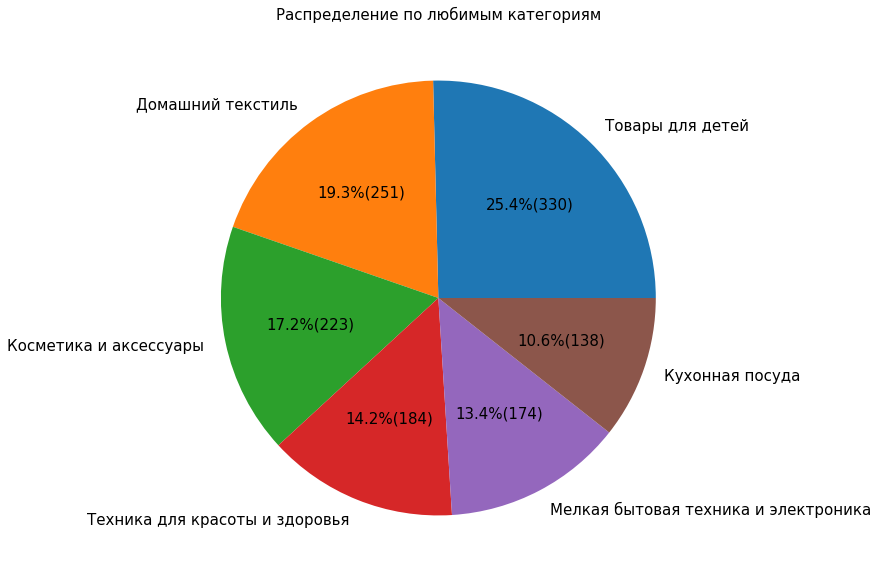

In [74]:
data_cat_graf = data_full_new['популярная_категория'].value_counts()
plt.title('Распределение по любимым категориям', fontsize=15)
data_cat_graf.plot(kind='pie', figsize =(10,10), fontsize=15,
                       autopct=lambda p: '{:.1f}%({:.0f})'.format(p,(p/100)*data_cat_graf.sum()))
plt.ylabel('');

Можно заметить, что наши категории, которые увеличивают шанс на прежнюю покупательскую активность занимают меньшую долю по любимым категориям.

Построим столбчатый график по самым важный признакам, чтобы более детально их проанализировать.

На графике выделим красным цветом категории которые не влияют на покупательскую активность, а зеленым те, что повышают.

Напишем функцию, чтобы выводить последовательно графики

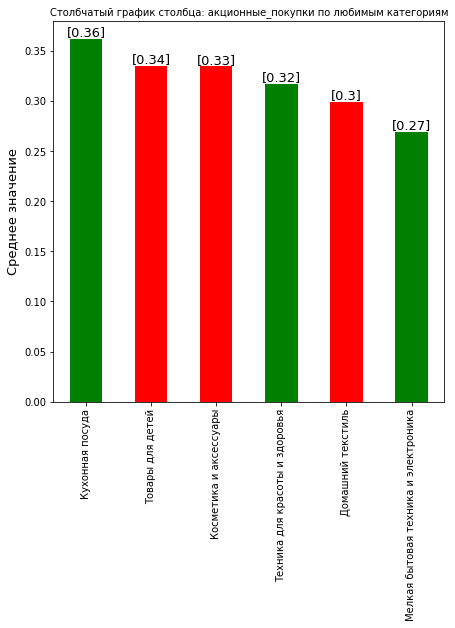

In [75]:
def favorite_cat(imp):
    data_category = data_full_new.pivot_table(index = 'популярная_категория', values = imp, aggfunc='mean')
    data_category = data_category.sort_values(by=imp, ascending=False)
    ax = data_category.plot(kind='bar', color='g', fontsize=10, figsize =(7,7))
    ax.patches[data_category.index.get_indexer(['Товары для детей'])[0]].set_facecolor('r')
    ax.patches[data_category.index.get_indexer(['Домашний текстиль'])[0]].set_facecolor('r')
    ax.patches[data_category.index.get_indexer(['Косметика и аксессуары'])[0]].set_facecolor('r')
    ax.get_legend().remove()
    for i, val in enumerate(data_category.values):
        plt.text(i, val, val.round(2),
                 horizontalalignment='center', 
                 verticalalignment='bottom', 
                 fontdict={'fontweight':500, 'size':13},
                 )
    plt.title(f'Столбчатый график столбца: {imp} по любимым категориям' , fontsize=10)
    plt.ylabel('Среднее значение',fontsize=13)
    plt.xlabel('')
    plt.show()
favorite_cat('акционные_покупки')

Можно увидеть, что для самой важной категории Мелкой бытовой техники, самая малая средняя доля клиентов которые покупают продукты по акции. Кухонная посуда хоть и в лидерах, но ее доля в общем датасете крайне мала, что может исказить данный показатель.

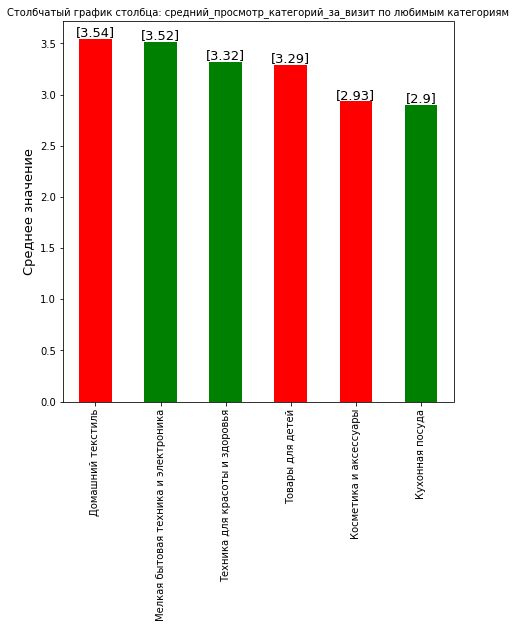

In [76]:
favorite_cat('средний_просмотр_категорий_за_визит')

Можно заметить, что существует 3 порога для данного параметра и в каждом по одному представителю из "зеленых" и "красных". По данному графику каких-то рекоммендации не сделать. 

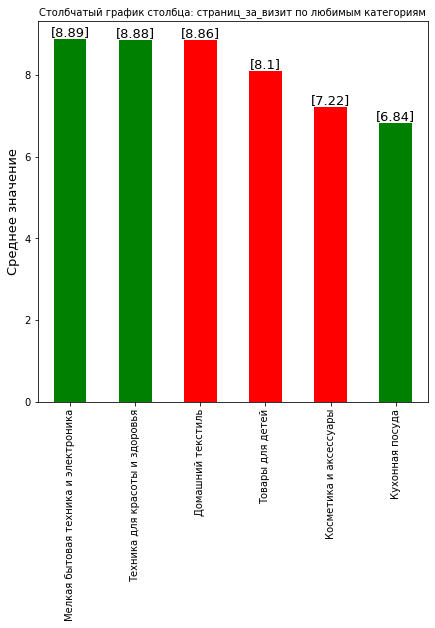

In [77]:
favorite_cat('страниц_за_визит')

Большое количество посещенных страниц за визит для техники, говорит о том, что клиент интересуется данной категорией и внимательно изучает товары в них. Как рекоммендация можно поработать над ассортиментом других категории, чтобы увеличить просматриваемость других категории товаров. 

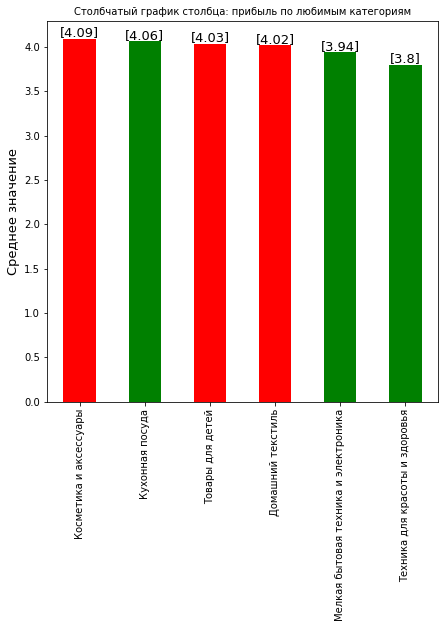

In [78]:
favorite_cat('прибыль')

Средняя прибыль немного меньше для техники, что говорит о привлекательности в ценах на товары. Как реккомендация можео ввести больше акционных предложении для "красных" категории, чтобы пользователи могли позволить себе их купить.

В данном случае мы сделали сегментацию по типу любимой категории, так как на графике SHAP была разница между ними. Как варианты решения проблем мы предложили поработать над ценой "красных" категории, увеличить их ассортимент, чтобы завлечь пользователя просматривать больше страниц, продумать акционную политику, которая повлияет на цены и т.д.

<a id='section9'></a>
##  Общий вывод

Нашей задачей было создание модели МО, чтобы предсказывать уменьшение покупательской активности для клиентов, а также предположить пути решения данной проблемы.

Во время предобработки данных мы почти не сталкнулись с пропусками, аномалиями, дубликатами. Немного подкорректировали некоторые значения которые были написаны с ошибками, исправили один выброс, так как имела место ошибка, объеденили данные в один датасет, чтобы учесть большее количество признаков

Чтобы найти лучшую модель мы использовали RandomizedSearchCV, чтобы оптимизировать время работы модели. Также мы вложили в пайплайн несколько кодировщиков (OneHotEncoder и OrdinalEncoder), для масштабирования количпественных признаков мы переберали разные скаллеры (StandardScaler и MinMaxScaler), а также использовали 4 разные модели МО (DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, SVC).

По результатам лучшей моделью оказалась LogisticRegression с гиперпараметрами С=2, solver = liblinear, penalty = l1 и с искользованием StandardScaler(). Точность данной модели для тестовой выборки составила 0.87

По результатам анализа данной модели мы вычислили, что самыми важными факторами для активности клиентов это сколько тратиться времени на сайте, сколько страниц просматривают клиенты и некоторые категории любимых товаров. При этом, когда мы анализировали категории, которые меньше всего в разделе популярная категория и они же являются сигналом к прежней активности, мы выяснили, что для них характерно большое количество маркетинговых активностей, а также они много времени просматиривают товары и листают много страниц, что может говорит о наличий заинтересованности и нужном ассортименте.